In [1]:
import datetime
import numpy

import matplotlib.pyplot as plt


from scipy.optimize import minimize


In [2]:
def read_b_model(file):
    data_file = numpy.loadtxt(file,dtype="str", delimiter= ',')
    r = data_file[:,0].astype(float)
    theta = data_file[:,1].astype(float)
    phi = data_file[:,2].astype(float)
    B_total = data_file[:,3].astype(float)

    return (r, theta, phi, B_total)

from numpy import sin, cos, tan, pi


def spherical_to_cartesian(r,theta,phi):
    phi = (360 - phi) /180 * pi
    theta = theta / 180 * pi
    x = r * sin(theta) * cos(phi)
    y = r * sin(theta) * sin(phi)
    z = r* cos(theta)
    return (x,y,z)

def length_magnetic_field_line(r, theta, phi):
    
    
    (x,y,z) = spherical_to_cartesian(r,theta,phi)
    cartesian_points = numpy.zeros((len(theta), 3))
    for i in range(cartesian_points.shape[0]):
        cartesian_points[i,:] = [x[i], y[i], z[i]]
    length_mfl_B = 0.0

    for i in range(1, len(cartesian_points)):
        length_mfl_B += numpy.linalg.norm(cartesian_points[i] - cartesian_points[i - 1])

    return length_mfl_B




# Function to calculate delta longitude
def delta_longitude_calculation(length_mfl_B_N_CS, length_mfl_B_N_out_CS,
                                length_mfl_B_S_CS, length_mfl_B_S_out_CS,
                                #B_integrated_N_CS, B_integrated_S_CS,
                                n_step_integration_N, n_step_integration_S,
                                B,
                                rho_integrated, v, R_J, rotation_rate_callisto):
    # Alfvén speed calculation
    mu_0 = 1.2566e-6  # Vacuum permeability
    
    c=3e8

    # Calculate the lengths
    length_mfl_B_S = length_mfl_B_S_CS + length_mfl_B_S_out_CS
    length_mfl_B_N = length_mfl_B_N_CS + length_mfl_B_N_out_CS

    
    ratio_N = (length_mfl_B_N_CS)/(length_mfl_B_N_CS+length_mfl_B_S_CS)
    ratio_S = (length_mfl_B_S_CS)/(length_mfl_B_N_CS+length_mfl_B_S_CS)
    
    #rho_integrated_norm = rho_integrated/(n_step_integration_N+n_step_integration_S)
    #if ratio_N!=0:
    #    v_A_N = numpy.sqrt((B_integrated_N_CS/n_step_integration_N) ** 2 / (mu_0 * rho_integrated_norm))
    #else:
    #    v_A_N = c
    #if ratio_S !=0:
    #    v_A_S = numpy.sqrt((B_integrated_S_CS/n_step_integration_S) ** 2 / (mu_0 * rho_integrated_norm))
    #else:
    #    v_A_S = c

    v_A = numpy.sqrt(B ** 2 / (mu_0 * rho_integrated))

    # Time calculation (t_TEB_CS and t_MAW_CS)
    t_TEB_CS = (length_mfl_B_S_CS * R_J / v_A# v_A_S 
                + length_mfl_B_S_out_CS * R_J / c 
                + (length_mfl_B_S + length_mfl_B_N) * R_J / c)
    
    t_MAW_CS = (length_mfl_B_N_CS * R_J /  v_A #v_A_N
                + length_mfl_B_N_out_CS * R_J / c)


    # Delta time and delta longitude
    Delta_t_CS = numpy.abs(t_TEB_CS - t_MAW_CS)
    delta_longitude_CS = Delta_t_CS * rotation_rate_callisto
    
    return delta_longitude_CS, t_MAW_CS, t_TEB_CS, Delta_t_CS, v_A #v_A_N, v_A_S #

# Objective function to minimize
def objective_function_delta_longitude(rho_integrated,
                                       length_mfl_B_N_CS, length_mfl_B_N_out_CS,
                                       length_mfl_B_S_CS, length_mfl_B_S_out_CS,
                                       B,#B_integrated_N_CS, B_integrated_S_CS,
                                       n_step_integration_N, n_step_integration_S,
                                       v, R_J, rotation_rate_callisto, delta_longitude_observed):


    
    # Calculate delta longitude based on the current guess of rho_integrated
    
    
    #delta_longitude_CS_calculated, _, _, _,_,_ =
    delta_longitude_CS_calculated, _, _, _,_, = delta_longitude_calculation(length_mfl_B_N_CS, length_mfl_B_N_out_CS,
                                                                         length_mfl_B_S_CS, length_mfl_B_S_out_CS,
                                                                         B,#B_integrated_N_CS, B_integrated_S_CS, 
                                                                         n_step_integration_N, n_step_integration_S,
                                                                         rho_integrated, v, R_J, rotation_rate_callisto)
    
    # Minimize the difference between calculated and observed delta longitude
    return (delta_longitude_CS_calculated - delta_longitude_observed) ** 2



# Define the density function
def rho_z(x_i, y_i, z_i, r_0, H, rho_0):
    r_i = numpy.sqrt(x_i**2 + y_i**2)
    density = rho_0 * numpy.exp(- numpy.sqrt((r_i - r_0)**2 + z_i**2) / H)
    return density

# Function to calculate the integrated density, accounting for the volume element
def integrated_density(x_vals, y_vals, z_vals, r_0, rho_0, H):
    # Calculate the spacing between points (assume equal spacing for simplicity)
    dx = numpy.abs(x_vals[1] - x_vals[0])
    dy = numpy.abs(y_vals[1] - y_vals[0])
    dz = numpy.abs(z_vals[1] - z_vals[0])
    
    if dx == 0:
        dx = 1
    if dy == 0:
        dy = 1
    if dz == 0:
        dz = 1
    
    volume_element = dx * dy * dz  # Volume element represented by each point
    total_volume = len(x_vals) * volume_element  # Total volume of the region
    
    # Sum over all points, multiplying density by volume element
    total_integrated_density = sum(
        rho_z(x_i, y_i, z_i, r_0, H, rho_0) #* volume_element
        for (x_i, y_i, z_i) in zip(x_vals, y_vals, z_vals)
    )

    # Check for total_volume
    if total_volume == 0:
        print("Error: Total volume is zero.")
        return numpy.nan  # or some error value
    
    # Check for nan in total_integrated_density
    if numpy.isnan(total_integrated_density):
        print("Error: Total integrated density is nan.")
        return numpy.nan  # or some error value

    # Normalize by the total volume to get density per unit volume
    normalized_density = total_integrated_density 

    return normalized_density


# Define the objective function to minimize (difference between calculated and observed integrated density)
def objective_function(rho_0, x_vals, y_vals, z_vals, integrated_density_observed, H, r_0):
    # Calculate the normalized integrated density
    integrated_density_calculated = integrated_density(x_vals, y_vals, z_vals, r_0, rho_0, H)
    
    # Compare calculated integrated density with observed value
    return (integrated_density_calculated - integrated_density_observed) ** 2



# Function to calculate integrated intensity and recalculated rho_0
def calculate_rho_0(integrated_intensity, H, a):
    """
    Calculate rho_0 from integrated intensity over a fraction a of the scale height H.
    
    integrated_intensity : float
        The integrated intensity over the range [0, a * H].
    H : float
        Scale height in planetary radius units (e.g., 1 R_p).
    a : float
        Fraction of the scale height over which the integration was performed (0 <= a <= 1).
    """
    return integrated_intensity / (H * (1 - numpy.exp(-a)))


In [ ]:
from plot_juno_mag_data_rtp import load_juno_mag_data_rtp
from plot_juno_mag_data_rtp import plot_juno_mag_data
from lobe_field_strength import load_lobe_field_strength,save_lobe_field_strength




time_start = datetime.datetime(2019, 9, 10, 0, 0)
time_end = datetime.datetime(2019, 9, 11, 10, 0)

 
file_ephem = "/Users/clouis/Documents/Data/ephemeris/Juno/juno_jup_xyz_jso_2016_2025.txt"
file_mag = "/Users/clouis/Documents/Data/Juno/FGM/juno_fgm_bxbybz_jso_orbits_2016-2024.txt"
	
(date_plot, b_plot, b_r_plot, b_th_plot, b_phi_plot) = load_juno_mag_data_rtp(time_start, time_end, 
                                                                    file_ephem = file_ephem, file_mag = file_mag)

directory_path_out="/Users/clouis/Documents/Etudes/Juno_moon_emissions/Callisto/PJ22_2019_09_12/MAG/"

plot_juno_mag_data(date_plot, b_plot, b_r_plot, b_th_plot,b_phi_plot, obsID = False, directory_path_out=directory_path_out,one_panel = True, labelsize=25, figsize=(32,16), legend = True, add_khurana_lobes_b_value = True)
(date_blobe,blobe) = load_lobe_field_strength(date_plot[0], date_plot[-1])
save_lobe_field_strength(date_blobe,blobe, directory_path_out=directory_path_out)

In [3]:
file_mag_model_north = "/Users/clouis/Documents/Etudes/Juno_moon_emissions/Callisto/PJ22_2019_09_12/Bmodel/Callisto_B_line_N_v2.txt"
file_mag_model_south = "/Users/clouis/Documents/Etudes/Juno_moon_emissions/Callisto/PJ22_2019_09_12/Bmodel/Callisto_B_line_S_v2.txt"

(r_N, theta_N, phi_N, B_total_N) = read_b_model(file_mag_model_north)
(r_S, theta_S, phi_S, B_total_S) = read_b_model(file_mag_model_south)

#B is in nT --> T
B_total_N = B_total_N*1e-9
B_total_S = B_total_S*1e-9

(x_N,y_N,z_N) = spherical_to_cartesian(r_N, theta_N, phi_N)
(x_S,y_S,z_S) = spherical_to_cartesian(r_S, theta_S, phi_S)

In [4]:
print(r_N.min(), r_N.max(), theta_N.min(), theta_N.max(), phi_N.min(), phi_N.max())
print(r_S.min(), r_S.max(), theta_S.min(), theta_S.max(), phi_S.min(), phi_S.max())

0.9502475505187392 26.546351709013408 13.01648051582058 90.23763002451538 53.06740586351891 109.56838300452743
0.952136312279306 26.329165120861916 90.23763002451538 163.09770643800215 37.769710848915366 54.165195452502154


In [5]:
[r, theta, phi] = 26.329, 90.237, 53.07

In [6]:
theta_d = 10.25 
phi_d = 360-196.38

theta_N_mag = (theta_N - cos((phi_d-phi)/180*numpy.pi)/numpy.pi*180)
theta_S_mag = (theta_S - cos((phi_d-phi)/180*numpy.pi)/numpy.pi*180)

In [7]:
length_mfl_B_N = length_magnetic_field_line(r_N, theta_N, phi_N)
length_mfl_B_S = length_magnetic_field_line(r_S, theta_S, phi_S)

print('MFL lengths:')
print(f'North: {length_mfl_B_N}')
print(f'South: {length_mfl_B_S}')

MFL lengths:
North: 30.059954866745578
South: 28.209954866745495


# No Current Sheet

In [8]:
m_e = 9.109e-31
keV = 1.602e-16 
E = numpy.array([1, 10])*keV
v = numpy.sqrt(2*E / m_e)
c = 3e8
R_J = 71492e3
rotation_rate_callisto =  0.0098
T_Callisto = 16.689*24*60*60
T_Jupiter = 0.41351*24*60*60
T_syn_Callisto = T_Callisto*T_Jupiter/numpy.abs(T_Callisto-T_Jupiter)
rotation_rate_syn_callisto = 360/T_syn_Callisto


longitude_theorique_callisto = 360-phi_N[-1]
longitude_mesuree_callisto = 297.7
lead_angle = numpy.abs(longitude_theorique_callisto - longitude_mesuree_callisto)
print(f'Observed Lead Angle is {lead_angle:.03f}')
t_A = T_syn_Callisto*lead_angle/360
print(f'Associated Alfvén Time with this lead angle @ Callisto subcorotation rate: {t_A:.03f}')



t_TEB_no_CS = length_mfl_B_S*R_J/c + (length_mfl_B_S+length_mfl_B_N)*R_J/v
t_MAW_no_CS = length_mfl_B_N*R_J/c
Delta_t_no_CS = t_TEB_no_CS - t_MAW_no_CS

delta_longitude_no_CS = Delta_t_no_CS * rotation_rate_callisto
print('')
print(f'Associated values without Current Sheet: \n'
        +r't$_{MAW}$ = ' + f'{t_MAW_no_CS} seconds'+'\n' 
        +r't$_{TEB}$ = ' + f'{t_TEB_no_CS} seconds'+ '\n'
        +r'$\Delta t$ = ' + f'{Delta_t_no_CS} seconds' + '\n'
        +r'$\Delta \lambda$ = ' + f'{delta_longitude_no_CS} degrees')

Observed Lead Angle is 47.268
Associated Alfvén Time with this lead angle @ Callisto subcorotation rate: 4810.212

Associated values without Current Sheet: 
t$_{MAW}$ = 7.163487644444583 seconds
t$_{TEB}$ = [228.84426951  76.96365322] seconds
$\Delta t$ = [221.68078187  69.80016558] seconds
$\Delta \lambda$ = [2.17247166 0.68404162] degrees


# With Current Sheet

1
North: in CS: 0.8833333333333148, out CS: 29.90825180138074
South: in CS: 0.0, out CS: 28.209954866745495

Electron Energy is 1.0 keV
Associated values with Current Sheet: 
t_MAW = inf seconds
t_TEB = nan seconds

Delta t = nan seconds
Observed Delta longitude:5.350°
Delta longitude = nan°
λ (MAW) from B model + t_MAW: -inf
λ (TEB) from B model + t_TEB: nan
H scale= 0.36470329790939376
density:
     699572922.48 m^-3 
     699.57 cm^-3

Electron Energy is 10.0 keV
Associated values with Current Sheet: 
t_MAW = inf seconds
t_TEB = nan seconds

Delta t = nan seconds
Observed Delta longitude:5.350°
Delta longitude = nan°
λ (MAW) from B model + t_MAW: -inf
λ (TEB) from B model + t_TEB: nan
H scale= 0.36470329790939376
density:
     699572922.48 m^-3 
     699.57 cm^-3
2


/var/folders/sy/kg6y02r14171n9z7znhm2_000000gn/T/ipykernel_24043/1723659083.py:71: RuntimeWarning: invalid value encountered in divide
  t_TEB_CS = (length_mfl_B_S_CS * R_J / v_A# v_A_S
/var/folders/sy/kg6y02r14171n9z7znhm2_000000gn/T/ipykernel_24043/1723659083.py:75: RuntimeWarning: divide by zero encountered in divide
  t_MAW_CS = (length_mfl_B_N_CS * R_J /  v_A #v_A_N
/var/folders/sy/kg6y02r14171n9z7znhm2_000000gn/T/ipykernel_24043/1723659083.py:71: RuntimeWarning: invalid value encountered in scalar divide
  t_TEB_CS = (length_mfl_B_S_CS * R_J / v_A# v_A_S
/var/folders/sy/kg6y02r14171n9z7znhm2_000000gn/T/ipykernel_24043/1723659083.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  t_MAW_CS = (length_mfl_B_N_CS * R_J /  v_A #v_A_N


North: in CS: 1.123333333333338, out CS: 28.93328820007892
South: in CS: 0.2299999999999924, out CS: 27.976621533412175

Electron Energy is 1.0 keV
Associated values with Current Sheet: 
t_MAW = 6.895 seconds
t_TEB = 20.552 seconds

Delta t = 13.657 seconds
Observed Delta longitude:5.350°
Delta longitude = 0.134°
λ (MAW) from B model + t_MAW: 306.86
λ (TEB) from B model + t_TEB: 306.72
H scale= 0.500591922605981
density:
     397696817.33 m^-3 
     397.70 cm^-3

Electron Energy is 10.0 keV
Associated values with Current Sheet: 
t_MAW = 6.895 seconds
t_TEB = 20.552 seconds

Delta t = 13.657 seconds
Observed Delta longitude:5.350°
Delta longitude = 0.134°
λ (MAW) from B model + t_MAW: 306.86
λ (TEB) from B model + t_TEB: 306.72
H scale= 0.500591922605981
density:
     397696817.33 m^-3 
     397.70 cm^-3
3
North: in CS: 1.6900000000000028, out CS: 28.366621533412278
South: in CS: 0.7666666666666668, out CS: 27.439954866745513

Electron Energy is 1.0 keV
Associated values with Current Sh

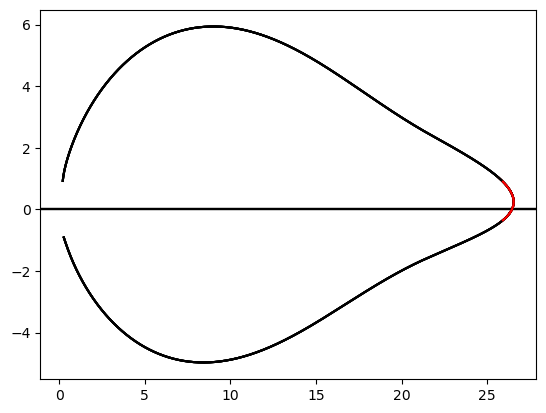

In [9]:

for assumption in range(1,6):
    print(assumption)
    equatorial_radius_N = numpy.sqrt(x_N**2 + y_N**2)
    equatorial_radius_S = numpy.sqrt(x_S**2 + y_S**2)
    if assumption == 1:
        # 1st assumption: Callisto is at the southern edge of the CS :
        mask_CS_S = theta_S < theta_S.min()
        mask_CS_N = r_N > r_S.max()
    elif assumption == 2:
        # 2nd assumption: we use z_N to determine the CS boundaries
        mask_CS_N = (z_N < 0.765) & (equatorial_radius_N > 2) # Second condition is to be sure no points close to the planet are taken
        mask_CS_S = equatorial_radius_S >= equatorial_radius_N[mask_CS_N].min()
    elif assumption == 3:
        # 2nd assumption: we use z_N to determine the CS boundaries
        mask_CS_N = (z_N < 1.038) & (equatorial_radius_N > 2) # Second condition is to be sure no points close to the planet are taken
        mask_CS_S = equatorial_radius_S >= equatorial_radius_N[mask_CS_N].min()
    elif assumption == 4:
        # 2nd assumption: we use z_N to determine the CS boundaries
        mask_CS_N = (z_N < 0.394) & (equatorial_radius_N > 2) # Second condition is to be sure no points close to the planet are taken
        mask_CS_S = equatorial_radius_S >= equatorial_radius_N[mask_CS_N].min()
    elif assumption == 5:
        # 2nd assumption: we use z_N to determine the CS boundaries
        mask_CS_N = (z_N < 0.9) & (equatorial_radius_N > 2) # Second condition is to be sure no points close to the planet are taken
        mask_CS_S = equatorial_radius_S >= equatorial_radius_N[mask_CS_N].min()

    elif assumption == 5:
        # 2nd assumption: we use z_N to determine the CS boundaries
        mask_CS_N = (z_N < 2) & (equatorial_radius_N > 2) # Second condition is to be sure no points close to the planet are taken
        mask_CS_S = equatorial_radius_S >= equatorial_radius_N[mask_CS_N].min()

    r_N_CS = r_N[mask_CS_N]
    theta_N_CS = theta_N[mask_CS_N]
    phi_N_CS = phi_N[mask_CS_N]
    B_total_N_CS = B_total_N[mask_CS_N]

    r_N_out_CS = r_N[~mask_CS_N]
    theta_N_out_CS = theta_N[~mask_CS_N]
    phi_N_out_CS = phi_N[~mask_CS_N]
    B_total_N_out_CS = B_total_N[~mask_CS_N]

    #mask_CS_S = theta_S_mag > 94

    r_S_CS = r_S[mask_CS_S]
    theta_S_CS = theta_S[mask_CS_S]
    phi_S_CS = phi_S[mask_CS_S]
    B_total_S_CS = B_total_S[mask_CS_S]

    r_S_out_CS = r_S[~mask_CS_S]
    theta_S_out_CS = theta_S[~mask_CS_S]
    phi_S_out_CS = phi_S[~mask_CS_S]
    B_total_S_out_CS = B_total_S[mask_CS_S]


    length_mfl_B_N_CS = length_magnetic_field_line(r_N_CS, theta_N_CS, phi_N_CS)
    length_mfl_B_S_CS = length_magnetic_field_line(r_S_CS, theta_S_CS, phi_S_CS)

    length_mfl_B_N_out_CS = length_magnetic_field_line(r_N_out_CS, theta_N_out_CS, phi_N_out_CS)
    length_mfl_B_S_out_CS = length_magnetic_field_line(r_S_out_CS, theta_S_out_CS, phi_S_out_CS)

    print(f'North: in CS: {length_mfl_B_N_CS}, out CS: {length_mfl_B_N_out_CS}')
    print(f'South: in CS: {length_mfl_B_S_CS}, out CS: {length_mfl_B_S_out_CS}')

    plt.plot(numpy.sqrt(x_N**2+y_N**2), z_N, 'k')
    plt.plot(numpy.sqrt(x_S**2+y_S**2), z_S, 'k')
    plt.axhline(y=0, xmin = 0, xmax = 25, color = 'k')

    plt.plot(numpy.sqrt(x_N[mask_CS_N]**2+y_N[mask_CS_N]**2), z_N[mask_CS_N], 'r')
    plt.plot(numpy.sqrt(x_S[mask_CS_S]**2+y_S[mask_CS_S]**2), z_S[mask_CS_S], 'r')

    # Constants
    mu_0 = 1.2566e-6  # Vacuum permeability
    c = 3e8           # Speed of light in m/s
    m_e = 9.10938356e-31  # Mass of electron in kg
    E_array = numpy.array([1, 10])*keV

    # Initial guess for rho_integrated
    rho_integrated_callisto_initial_guess = 8.4e4 / 1e-6 * m_e  # rho is the mass density (kg/m^3)

    B_array = numpy.array([5.5, 8.80, 12])*1e-9
    #B_array = numpy.array([8.32-2.44, 10.46+1.24, 35]) * 1e-9  # Magnetic field strength in Tesla # 1er test : 35 nT
    delta_longitude_observed = 5.35  # Observed delta longitude

    log = True
    log_full = False

    #for B in B_array:
    B = B_array[1]
    for E in E_array:
        if log:
            print('')
            #print(f'Magnetic field is {B:2E} nT and Electron Energy is {E/keV} keV')
            print(f'Electron Energy is {E/keV} keV')
        v = numpy.sqrt(2*E / m_e)
        # Minimization process
        result = minimize(
            objective_function_delta_longitude,           # Objective function
            rho_integrated_callisto_initial_guess,        # Initial guess for rho_integrated
            args=(length_mfl_B_N_CS, length_mfl_B_N_out_CS,
                length_mfl_B_S_CS, length_mfl_B_S_out_CS,
                B,#numpy.sum(B_total_N_CS), numpy.sum(B_total_S_CS),
                len(mask_CS_N[mask_CS_N == True]), len(mask_CS_S[mask_CS_S == True]),
                v, R_J, rotation_rate_callisto, delta_longitude_observed),  # Additional args
            method='Nelder-Mead',                         # Optimization method
            tol=1e-6                                      # Tolerance for convergence
        )


        # Extract the optimal rho_integrated value
        rho_integrated_optimal = result.x[0]

        rho_integrated_callisto = rho_integrated_optimal
        # Output the results
        if log_full:
            print(f'Op  timal rho_integrated: {rho_integrated_callisto} kg/m^3')
            print(f'Optimal rho_integrated: {rho_integrated_callisto/m_e:2E} m^-3 \n{rho_integrated_callisto / 1e6/m_e:2E} cm^-3')

        # Calculate associated values with the optimal rho_integrated
        
        #delta_longitude_CS, t_MAW_CS, t_TEB_CS, Delta_t_CS, v_A_N, v_A_S 
        delta_longitude_CS, t_MAW_CS, t_TEB_CS, Delta_t_CS, v_A= delta_longitude_calculation(length_mfl_B_N_CS, length_mfl_B_N_out_CS,
                                                                                        length_mfl_B_S_CS, length_mfl_B_S_out_CS,
                                                                                        B, #numpy.sum(B_total_N_CS), numpy.sum(B_total_S_CS),
                                                                                        len(mask_CS_N[mask_CS_N == True]), len(mask_CS_S[mask_CS_S == True]),
                                                                                        rho_integrated_callisto, v, R_J, rotation_rate_callisto)
        if log_full:
            print(f'Ratio between Alfvén Speed and electron velocity: {v_A / v:2E}')
        # Print associated values with the current sheet
        if log:
            print(f'Associated values with Current Sheet: \n'
                f't_MAW = {t_MAW_CS:.3f} seconds\n'
                f't_TEB = {t_TEB_CS:.3f} seconds\n')
        
            print(f'Delta t = {Delta_t_CS:.3f} seconds\n'
                f'Observed Delta longitude:{delta_longitude_observed:.3f}°\n'
                f'Delta longitude = {delta_longitude_CS:.3f}°')

        lambda_theoretical_N = 360-phi_N[0]
        lambda_observed_MAW = 297.7
        lambda_observed_TEB = 303.05

        if log_full:
            print(f'λ (MAW) from UV measurement: {lambda_observed_MAW:.02f}')
            print(f'λ (TEB) from UV measurement: {lambda_observed_TEB:.02f} \n')
            print('')
            print(f'λ from B model: {lambda_theoretical_N}')
        if log:
            print(f'λ (MAW) from B model + t_MAW: {lambda_theoretical_N+t_MAW_CS*-1*rotation_rate_callisto:.02f}')
            print(f'λ (TEB) from B model + t_TEB: {lambda_theoretical_N+t_TEB_CS*-1*rotation_rate_callisto:.02f}')


        # Constants
        Rp = 71492e3  # Planetary radius in m
        r_0_callisto = 26.33 * Rp  # r_0 in m


        # Initial guess for rho_0

        x_vals_callisto = numpy.concatenate((x_N[mask_CS_N], x_S[mask_CS_S]))*Rp
        y_vals_callisto = numpy.concatenate((y_N[mask_CS_N], y_S[mask_CS_S]))*Rp
        z_vals_callisto = numpy.concatenate((z_N[mask_CS_N], z_S[mask_CS_S]))*Rp

        H_callisto =  (z_vals_callisto.max() - z_vals_callisto.min())/2 # Scale height in m
        if log:
            print(f'H scale= {H_callisto/Rp}')
        integrated_density_observed_callisto = rho_integrated_callisto/m_e


        # Initial guess for rho_0
        rho_0_initial_guess_callisto = 20/1e-6  # Example value
        if log_full:
            print(f'integrated density:\n     {integrated_density_observed_callisto:2E} m^-3 \n     {integrated_density_observed_callisto / 1e6:2E} cm^-3')
        # Minimize the objective function to find rho_0
        result = minimize(
            objective_function,          # Objective function to minimize
            rho_0_initial_guess_callisto,         # Initial guess for rho_0
            args=(x_vals_callisto,
                y_vals_callisto,
                z_vals_callisto, integrated_density_observed_callisto, H_callisto, r_0_callisto),  # Additional arguments for the objective function
            method='Nelder-Mead',        # Optimization method, 'Nelder-Mead' is a good choice for non-linear problems
            tol=1e-6                     # Tolerance level for stopping the optimization
        )

        rho_0_optimal = result.x[0]  # Extract the optimal rho_0 from the result
        if log:
            print(f'density:\n     {rho_0_optimal:.02f} m^-3 \n     {rho_0_optimal/1e6:.02f} cm^-3')






Measured H scale by Juno on 2019-09-10


In [10]:


[r_out_14h10, theta_out_14h10, phi_out_14h10] = 22.79, 90-(-1.4), 360-227
x_out_14h10, y_out_14h10, z_out_14h10 = spherical_to_cartesian(r_out_14h10, theta_out_14h10, phi_out_14h10)
[r_center_15h50, theta_center_15h50, phi_center_15h50] = 26.98, 90-(1.01), 360-287.5
x_center_15h50, y_center_15h50, z_center_15h50 = spherical_to_cartesian(r_center_15h50, theta_center_15h50, phi_center_15h50)

